Exploratory Data Analysis

In [54]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import dlib
from sklearn.model_selection import train_test_split
from google.colab import drive 
from google.colab.patches import cv2_imshow
drive.mount('/content/gdrive')
df = pd.read_csv('gdrive/My Drive/age_gender.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [55]:
# Returns an Image object given the row number in the age_gender.csv dataset
def draw_face(row_num, df_row):
  df_row = [int(i) for i in df_row[row_num].split()]
  pixels = []
  for i in range(0, 48):
    temp = []
    for j in range(0, 48):
      temp.append(df_row[i * 48 + j])
    pixels.append(temp)
  array = np.array(pixels, dtype=np.uint8)
  return array

In [56]:
# Returns a tuple containing a rescaled image and the greyscale version of the rescaled image respectively in numpy array form
def resize_and_grey_image(image_array, target_area):
  sf = target_area / (image_array.shape[0] + image_array.shape[1])
  image_array = cv2.cvtColor(cv2.resize(image_array, dsize = ((int) (image_array.shape[1] * sf), (int) (image_array.shape[0] * sf))), cv2.COLOR_BGR2RGB)
  try:
    image_grey = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)
    return (image_array, image_grey)
  except:
    image_grey = np.stack((image_array,) * 3, axis=-1)
    return (image_grey, image_grey)

In [57]:
# Predicts gender and age by outputting picture with predicted gender and age range given a image array of the picture
def age_and_gender_predict(init_image):
  normal, grey = resize_and_grey_image(init_image, 1000)
  age_weights = "/content/gdrive/MyDrive/age_deploy.prototxt"
  age_config = "/content/gdrive/MyDrive/age_net.caffemodel"
  gender_weights = '/content/gdrive/MyDrive/deploy_gender.prototxt'
  gender_config = '/content/gdrive/MyDrive/gender_net.caffemodel'
  gender_list = ['Male', 'Female']
  gender_net = cv2.dnn.readNetFromCaffe(gender_weights, gender_config)
  msg = "Face Detected"
  age_list = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
  age_net = cv2.dnn.readNet(age_config, age_weights)
  model_mean = (78.4263377603, 87.7689143744, 114.895847746)
  boxes = []
  face_detector = dlib.get_frontal_face_detector()
  faces = face_detector(grey)
  if not faces:
    print("No faces detected")
    msg = "No face detected"
    cv2.putText(normal, f'{msg}', (40, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (200), 2)
    cv2_imshow(cv2.cvtColor(normal,cv2.COLOR_BGR2RGB))
  else:
    for face in faces:
      x = face.left()
      if x < 0:
        x = 30
      y = face.top()
      if y < 0:
        y = 30
      x2 = face.right()
      if x2 > normal.shape[1]:
        x2 = normal.shape[1] - 30
      y2 = face.bottom()
      if y2 > normal.shape[0]:
        y2 = normal.shape[0] - 30
      box = [x, y, x2, y2]
      boxes.append(box)
      cv2.rectangle(normal, (x, y), (x2, y2), (00, 200, 200), 2)
    i = 1
    for box in boxes:
      face = normal[box[1]:box[3], box[0]:box[2]]
      blob = cv2.dnn.blobFromImage(face, 1.0, (227, 227), model_mean, swapRB=False)
      age_net.setInput(blob)
      age_preds = age_net.forward()
      age = age_list[age_preds[0].argmax()]
      gender_net.setInput(blob)
      gender_preds = gender_net.forward()
      g = gender_preds[0].argmax()
      gender = gender_list[g]
      msg = gender      
      cv2.putText(normal, f'{msg}:{age}', (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2, cv2.LINE_AA)
      if i == len(boxes):
        cv2_imshow(cv2.cvtColor(normal,cv2.COLOR_BGR2RGB))
      i += 1

In [58]:
df = df.drop('img_name', axis = 1)
visual_df = df.drop('pixels', axis = 1)

[Text(0.5, 0, 'Age'), Text(0.5, 1.0, 'Frequency of Ages')]

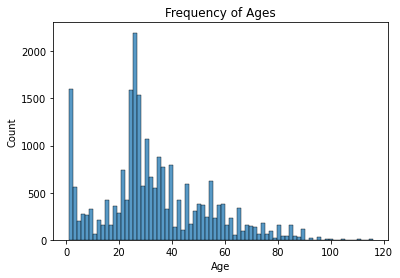

In [59]:
sns.histplot(data = visual_df, x = "age").set(title = "Frequency of Ages", xlabel = "Age")

Text(0.5, 1.0, 'Distribution of Ethnicities')

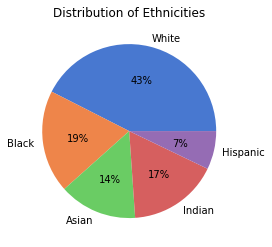

In [60]:
colors = sns.color_palette("muted")
freq = [0, 0, 0, 0, 0]
labels = ["White", "Black", "Asian", "Indian", "Hispanic"]
for i in df['ethnicity']:
  freq[i] += 1
plt.pie(freq, labels = labels, colors = colors, autopct='%.0f%%')
plt.title("Distribution of Ethnicities")

Text(0.5, 1.0, 'Distribution of Genders')

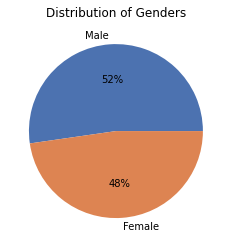

In [61]:
colors2 = sns.color_palette("deep")
freq2 = [0, 0]
labels2 = ["Male", "Female"]
for i in df['gender']:
  freq2[i] += 1
plt.pie(freq2, labels = labels2, colors = colors2, autopct='%.0f%%')
plt.title("Distribution of Genders")

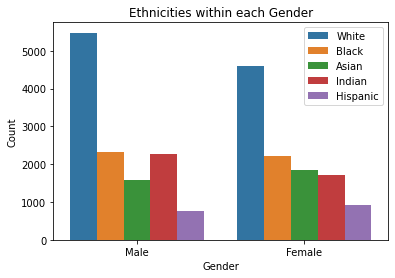

In [62]:
temp0 = visual_df.copy()
temp0['gender'] = temp0['gender'].replace([0],'Male')
temp0['gender'] = temp0['gender'].replace([1],'Female')
sns.countplot(x = temp0['gender'], hue = temp0["ethnicity"]).set(title = "Ethnicities within each Gender", xlabel = "Gender", ylabel = "Count")
plt.legend(labels = ["White", "Black", "Asian", "Indian", "Hispanic"])

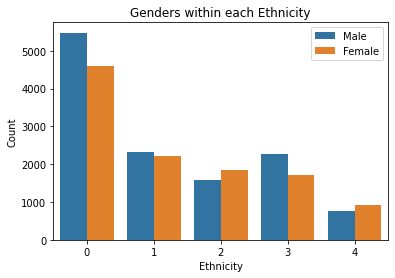

In [63]:
temp = visual_df.copy()
temp['ethnicity'] = temp['ethnicity'].replace([0],'White')
temp['ethnicity'] = temp['ethnicity'].replace([1],'Black')
temp['ethnicity'] = temp['ethnicity'].replace([2],'Asian')
temp['ethnicity'] = temp['ethnicity'].replace([3],'Indian')
temp['ethnicity'] = temp['ethnicity'].replace([4],'Hispanic')
sns.countplot(x = visual_df['ethnicity'], hue = visual_df["gender"]).set(title = "Genders within each Ethnicity", xlabel = "Ethnicity", ylabel = "Count")
plt.legend(labels = ["Male", "Female"])

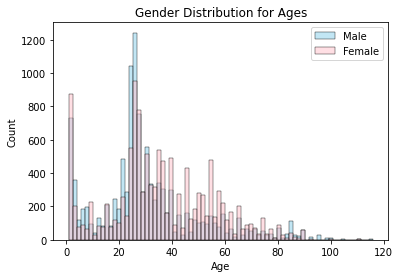

In [64]:
sns.histplot(data = visual_df, x = "age", hue = "gender", palette = ["pink", "skyblue"]).set(title = "Gender Distribution for Ages", xlabel = "Age")
plt.legend(labels = ["Male", "Female"])

[Text(0.5, 0, 'Age'), Text(0.5, 1.0, 'Frequency of Ages for Hispanic')]

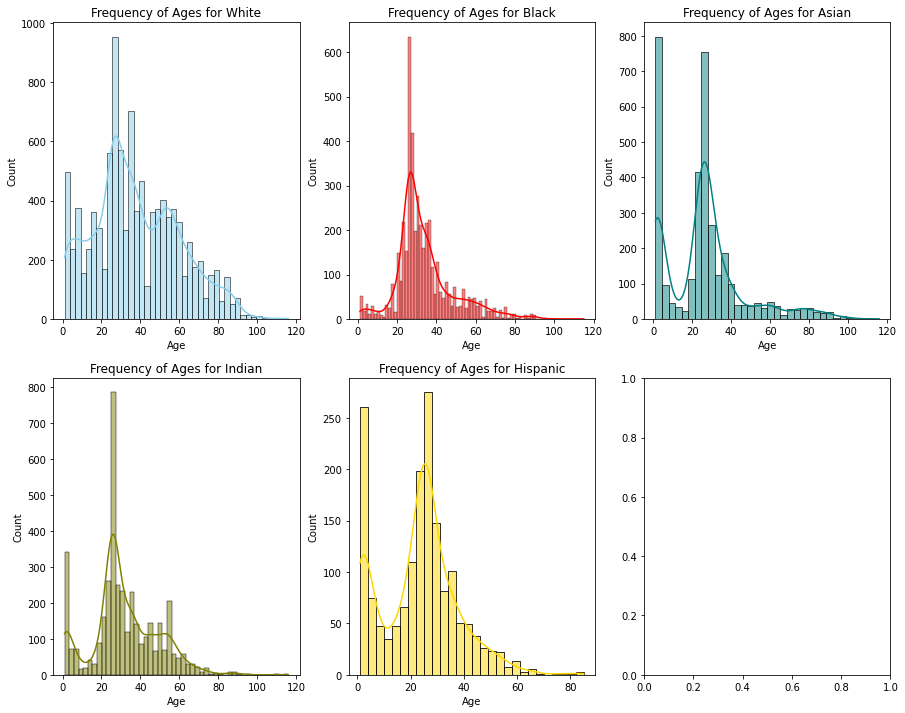

In [65]:
fig, axs = plt.subplots(2, 3, figsize = (15, 12))
sns.histplot(data = visual_df[visual_df['ethnicity'] == 0], x = "age", kde = True, color = "skyblue", ax = axs[0, 0]).set(title = "Frequency of Ages for White", xlabel = "Age")
sns.histplot(data = visual_df[visual_df['ethnicity'] == 1], x = "age", kde = True, color = "red", ax = axs[0, 1]).set(title = "Frequency of Ages for Black", xlabel = "Age")
sns.histplot(data = visual_df[visual_df['ethnicity'] == 2], x = "age", kde = True, color = "teal", ax = axs[0, 2]).set(title = "Frequency of Ages for Asian", xlabel = "Age")
sns.histplot(data = visual_df[visual_df['ethnicity'] == 3], x = "age", kde = True, color = "olive", ax = axs[1, 0]).set(title = "Frequency of Ages for Indian", xlabel = "Age")
sns.histplot(data = visual_df[visual_df['ethnicity'] == 4], x = "age", kde = True, color = "gold", ax = axs[1, 1]).set(title = "Frequency of Ages for Hispanic", xlabel = "Age")

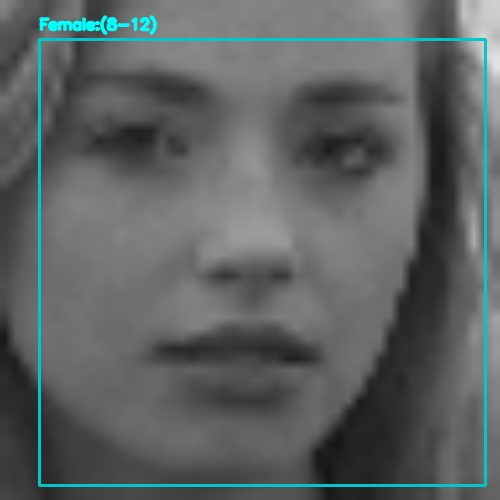

In [67]:
# Reading from our dataset
baby_face = draw_face(1999, df['pixels'])
age_and_gender_predict(baby_face)

# Reading from any image
# iu = cv2.imread('/content/gdrive/MyDrive/iu.jpg')
# age_and_gender_predict(iu)


In [68]:
age_correct = 0
total_age = 0
gender_correct = 0
total_gender = 0
age_weights = "/content/gdrive/MyDrive/age_deploy.prototxt"
age_config = "/content/gdrive/MyDrive/age_net.caffemodel"
gender_weights = '/content/gdrive/MyDrive/deploy_gender.prototxt'
gender_config = '/content/gdrive/MyDrive/gender_net.caffemodel'
gender_list = ['Male', 'Female']
gender_net = cv2.dnn.readNetFromCaffe(gender_weights, gender_config)
age_list = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
age_net = cv2.dnn.readNet(age_config, age_weights)
model_mean = (78.4263377603, 87.7689143744, 114.895847746)
face_detector = dlib.get_frontal_face_detector()
good = False
for i in range(0, 100):
  color = resize_and_grey_image(draw_face(i, df["pixels"]), 1000)[0]
  try:
    face = face_detector(color)
    if len(face) == 1:
      total_age += 1
      total_gender += 1
      good = True
  except:
    pass
  if good:
    face = face[0]
    x = face.left()
    if x < 0:
      x = 30
    y = face.top()
    if y < 0:
      y = 30
    x2 = face.right()
    if x2 > color.shape[1]:
      x2 = color.shape[1] - 30
    y2 = face.bottom()
    if y2 > color.shape[0]:
      y2 = color.shape[0] - 30
    box = [x, y, x2, y2]
    blob = cv2.dnn.blobFromImage(color[box[1]:box[3], box[0]:box[2]], 1.0, (227, 227), model_mean, swapRB=False)
    age_net.setInput(blob)
    age_preds = age_net.forward()
    gender_net.setInput(blob)
    gender_preds = gender_net.forward()
    predicted_age = age_preds[0].argmax()
    predicted_gender = gender_preds[0].argmax()
    if (df["age"][i] > 0 and df["age"][i] < 4 and predicted_age == 0) or (df["age"][i] >= 4 and df["age"][i] < 8 and predicted_age == 1) or (df["age"][i] >= 8 and df["age"][i] < 14 and predicted_age == 2) or (df["age"][i] >= 14 and df["age"][i] < 24 and predicted_age == 3) or (df["age"][i] >= 24 and df["age"][i] < 36 and predicted_age == 4) or (df["age"][i] >= 36 and df["age"][i] < 46 and predicted_age == 5) or (df["age"][i] >= 46 and df["age"][i] < 58 and predicted_age == 6) or (df["age"][i] >= 58 and predicted_age == 7):
      age_correct += 1
    if (df["gender"][i] == predicted_gender):
      gender_correct += 1
  good = False
print(str(age_correct/total_age * 100)[:8] + "%")
print(str(gender_correct/total_gender * 100)[:8] + "%")

33.33333%
39.58333%
